MNIST VAE
==

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import clear_output
import sys
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', data_home='.')
print mnist.data.shape


(70000, 784)


In [42]:
def matmul(X, dout, name):
    with tf.variable_scope(name):
        _, dX = X.get_shape()
        W = tf.get_variable('W', shape=(dX, dout))
        b = tf.get_variable('b', initializer=tf.constant(np.zeros(dout).astype(np.float32)))
    return tf.matmul(X, W)+b

def assert_shape(tens, shape):
    assert tens.get_shape().is_compatible_with(shape)

def relu_layer(X, dout, name):
    return tf.nn.softplus(matmul(X, dout, name))
def tanh_layer(X, dout, name):
    return tf.nn.tanh(matmul(X, dout, name))

class VAE(object):
    def __init__(self, dX, dZ, enc_layers = (128,64), dec_layers=(64,128), lamb=1e-2):
        self.enc_layers = enc_layers
        self.dec_layers = dec_layers
        self.dZ = dZ
        self.dX = dX
        self.lamb = lamb

        self._build_network(dX, dZ)
        self._init_tf()

    def _build_network(self, dX, dZ):

        self.X = X = tf.placeholder(tf.float32, shape=(None, dX), name='X')
        self.noise = tf.placeholder(tf.float32, shape=(None, dZ), name='Z')
        self.lr = tf.placeholder(tf.float32, shape=tuple(), name='lr')

        # Encoding
        mu_enc, log_var_enc = self._encode(self.X)
        self.mu = mu_enc
        self.log_var = log_var_enc
        assert_shape(self.mu, [None, self.dZ])
        assert_shape(self.log_var, [None, self.dZ])

        self.var = var_enc = tf.exp(log_var_enc)

        # Decoding
        enc_output = self.noise*tf.sqrt(var_enc) + mu_enc
        assert_shape(enc_output, [None, self.dZ])
        mu_dec = self._decode(enc_output)
        self.mu_dec = mu_dec
        assert_shape(mu_dec, [None, self.dX])
        
        # re-encode
        mu_enc2, log_var_enc2 = self._encode(mu_dec, reuse=True)
        #code_err = -tf.reduce_sum(tf.square(mu_enc2 - mu_enc) , reduction_indices=1)
        code_err = self.lamb*tf.reduce_sum(0.5 * log_var_enc2 + (tf.square(mu_enc2-mu_enc)/(2.0 * tf.exp(log_var_enc))), 1)


        
        # Sample decode
        self.sample_Z = tf.placeholder(tf.float32, shape=(None, dZ), name='Z_sample')
        self.sample_mu = self._decode(self.sample_Z, reuse=True)
            
        # Losses
        logpxz = -tf.reduce_sum(X * tf.log(1e-6 + mu_dec) + (1-X) * tf.log(1e-6 + 1 - mu_dec), reduction_indices=1)
        kldiv = 0.5 * tf.reduce_sum(1 + log_var_enc - tf.square(mu_enc) - tf.exp(log_var_enc), reduction_indices=1)
        self.loss = tf.reduce_mean(logpxz - kldiv + code_err)
        self.stepfn = tf.train.AdamOptimizer(self.lr).minimize(self.loss)
        
    def _encode(self, _X, reuse=False):
        encoding = _X
        with tf.variable_scope('encoder', reuse=reuse):
            for i, layer_size in enumerate(self.enc_layers):
                encoding = relu_layer(encoding, layer_size, name='enc_%d'%i)
            mu_enc = matmul(encoding, dZ, name='enc_mu')
            log_var_enc = matmul(encoding, dZ, name='enc_sig')
        return mu_enc, log_var_enc
    
    def _decode(self, output, reuse=False):
        with tf.variable_scope('decoder', reuse=reuse):
            for i, layer_size in enumerate(self.dec_layers):
                output = relu_layer(output, layer_size, name='dec_%d'%i)
            mu_dec = tf.nn.sigmoid(matmul(output, self.dX, name='dec_mu'))
        return mu_dec

    def _init_tf(self):
        self.sess = tf.Session()
        self.sess.run(tf.initialize_all_variables())

    def step(self, X, lr=0.1):
        batch_size = X.shape[0]
        z = np.random.randn(batch_size, self.dZ)
        loss, _ = self.sess.run([self.loss, self.stepfn],
                feed_dict={ self.X: X, 
                            self.noise:z,
                            self.lr: lr})
        return loss

    def encode(self, X):
        mu, sigma = self.sess.run([self.mu, self.var],
                feed_dict={ self.X: X})
        return mu, sigma
    
    def encode_decode(self, X):
        batch_size = X.shape[0]
        z = np.random.randn(batch_size, self.dZ)
        mu, mu_dec = self.sess.run([self.mu, self.mu_dec],
                          feed_dict={self.X: X, self.noise:z})
        return mu, mu_dec
    
    def decode(self, enc):
        enc = np.expand_dims(enc, axis=0)
        mu_dec = self.sess.run(self.sample_mu, {self.sample_Z: enc})
        return mu_dec
    
    def sample(self, N):
        Z = np.random.randn(N, self.dZ)
        mu_dec = self.sess.run(self.sample_mu, {self.sample_Z: Z})
        return mu_dec
        
        
def mnist_data(batch_size, dataset=mnist.data):
    #dataset = np.array([dataset[1230], dataset[51111], dataset[30000]])
    idx = np.random.randint(low=0, high=len(dataset), size=batch_size)
    return dataset[idx,:]

def spiral_data(batch_size, spiral_rate=1.):
    T = 10
    t = np.random.uniform(size=batch_size, low=0, high=T)
    x = t*np.cos(t*spiral_rate)/T
    y = t*np.sin(t*spiral_rate)/T
    data = np.array([x,y]).T
    noise = np.random.randn(batch_size,2)/(T*2)
    return data+noise

Training & Test
===

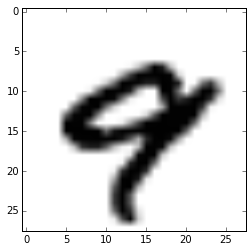

In [19]:
sample_distribution = lambda x: mnist_data(x)/255.
example = sample_distribution(1)[0]
example = np.reshape(example, [28,28])
plt.imshow(example, cmap='Greys')
plt.show()

In [59]:
#Training
tf.reset_default_graph()
np.random.seed(2)
dX = sample_distribution(1).shape[1]
dZ = 2
batch_size = 32
vae = VAE(dX, dZ, enc_layers=[512,512], dec_layers=[512,512], lamb=1.)

tot_loss = 0
heartbeat = 100
losses = []
for i in range(2000):
    x = sample_distribution(batch_size)
    loss = vae.step(x, lr=2e-3)
    tot_loss += loss
    if i%heartbeat == 0 and i>0:
        #clear_output()
        print i, tot_loss/heartbeat
        losses.append(tot_loss/heartbeat)
        sys.stdout.flush()
        tot_loss = 0
        #mus, sigmas = vae.encode(x)
        #print np.mean(mus, axis=1)
        #print np.mean(sigmas, axis=1)

0 6.53732910156
100 203.27556015
200 177.053203735
300 171.389359894
400 170.524316559
500 167.746643524
600 167.284952545
700 166.326285858
800 164.89960144
900 162.111015167
1000 163.876731873
1100 161.396766815
1200 161.848406525
1300 160.420500336
1400 159.966192627
1500 165.062310028
1600 158.200091095
1700 157.917318268
1800 156.462665253
1900 163.978270721


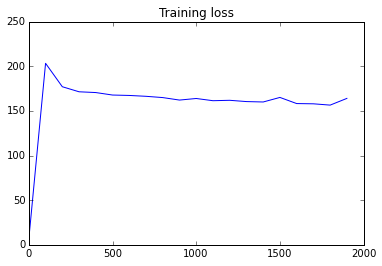

In [60]:
# Training plot
plt.title("Training loss")
plt.plot(np.arange(len(losses))*heartbeat, losses)
plt.show()

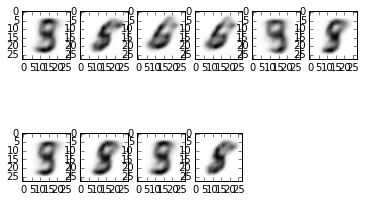

In [61]:
# Try sampling!
np.set_printoptions(suppress=True)
samples = vae.sample(10)

rows = 2
cols = len(samples)/2 +1
plt.figure()
for i, samp in enumerate(samples):
    plt.subplot(rows, cols, i+1)
    example = np.reshape(samp, [28,28])
    #print example
    plt.imshow(example, cmap='Greys')
plt.show()


[[-2.24868941 -0.36019632]]


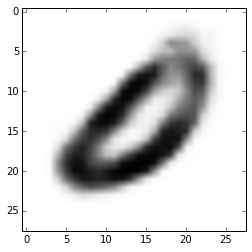

[[ 0.2567369 -0.5297966]]


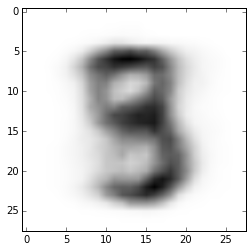

In [62]:
#encodings
imgs = [mnist.data[1230]/255., mnist.data[51111]/255.]
for img in imgs:
    encoding, decode = vae.encode_decode(np.expand_dims(img, axis=0))
    print encoding
    example = np.reshape(decode[0], [28,28])
    plt.imshow(example, cmap='Greys')
    plt.show()

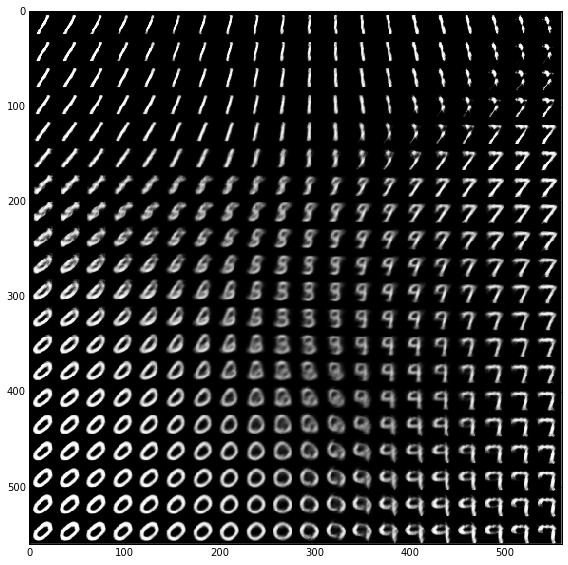

In [63]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)
canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([xi, yi])
        x_mean = vae.decode(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
plt.tight_layout()

In [67]:
all_z, all_z_sig = vae.encode(mnist.data/255.)        

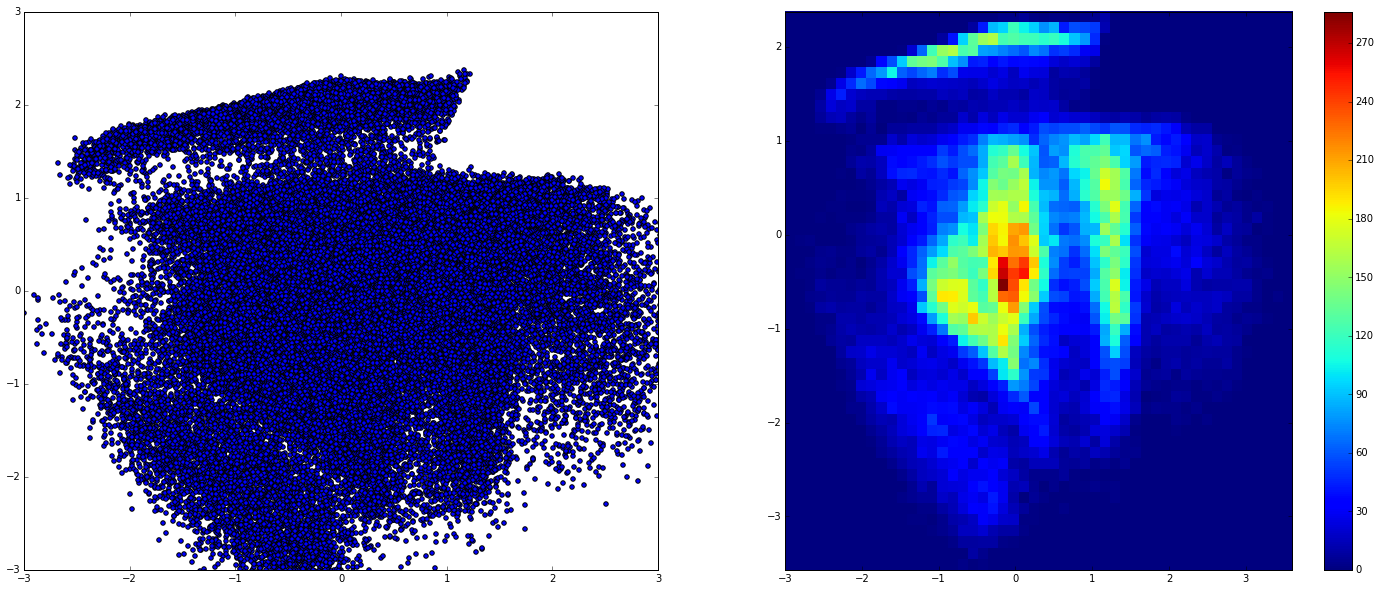

In [69]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.scatter(all_z[:,0], all_z[:,1])
plt.xlim(-3,3)N
plt.ylim(-3,3)
plt.subplot(1,2,2)
plt.hist2d(all_z[:,0], all_z[:,1], (50, 50), cmap=plt.cm.jet)
plt.colorbar()
plt.show()